# CLEAN CREDITS DATA AND CREATE GRAPH FILES
* Read in DISCOGS artist database to map common name aliases. 
* Read in, parse and clean Wikipedia data (ignore additional DISCOGS for now).
* Pivot into network tables, drop small time producers and attain network layout.

In [1]:
import re
import pickle
import operator
import xmltodict
import numpy as np
import pandas as pd
from gzip import GzipFile
from itertools import chain, combinations
from collections import Counter
from ggplot import *
%matplotlib inline

# packages for creating playlists
import spotipy
import spotipy.util as util
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
# LOAD DATAFRAMES
all_tracks = pd.read_pickle('../02_data/all_tracks.p')
artist_lookup = pickle.load(open('../02_data/artist_lookup.p', 'rb'))

# how many additional tracks did discogs pull in?
len(all_tracks[(all_tracks.credits.notnull()) & (all_tracks.credits!=set())])
# not worth the effort...

161

In [3]:
# load discogs artist lookups to clean/crosswalk artist names
# this isn't a foolproof way of cleaning up the artist names but it prevents a lot of manual work
# if there is a "chris brown" who is not more popular "THE chris brown" they might get mapped to the same name
# however, if i preemptively filter out low-impact tracks this should reduce any of those issues.
name_lookup = {}
def handle_artist(_, artist):
    if artist['data_quality'] in ['Complete And Correct', 'Correct']:
        try:
            variation = artist['namevariations']['name']
            name_lookup[artist['name']] = [variation] if isinstance(variation, str) else variation
        except:
            name_lookup[artist['name']] = []
    else:
        pass
    return True

xmltodict.parse(GzipFile('../02_data/discogs_20170801_artists.xml.gz'), item_depth=2, item_callback=handle_artist)

# create variations lookup.
# if 2 variations map to the same key then nuke it
var_lu = {}
for name, variations in name_lookup.items():
    if len(variations)>0:
        for var in variations:
            if name in var_lu:
                var_lu[name] = None
            else:
                var_lu[var] = name

#del name_lookup # free up memory

In [4]:
# determine most important credit info obtained from wiki scrape
fields = []
for i in all_tracks.wiki:
    try:
        fields.extend(list(i.keys()))
    except:
        pass
sorted(Counter(fields).items(), key=operator.itemgetter(1), reverse=True)[:10]
# want to parse out: composer, producer, writer (maybe: artist, recorded, released?)

[('name', 6239),
 ('genre', 6140),
 ('label', 6114),
 ('artist', 5847),
 ('released', 5682),
 ('length', 5676),
 ('producer', 5675),
 ('cover', 5590),
 ('writer', 5358),
 ('recorded', 5191)]

In [5]:
# this regex function splits out artist strings into separate entities and keeps the first.
def parse_list(dirty):
    # some regex taken from https://github.com/Ran4/argus/blob/15717a9a4fd6c4fe05e6b75afabd68fa25ce4bd4/src/_old_attribute_value_parser.py
    dirty   = re.sub(r'\[\[(.*?)\|(.*?)\]\]', r'[[\1<aka>\2]]', dirty)
    dirty   = re.sub(r' <small>(.*)</small>', r'', dirty).replace('flat list', 'flatlist').replace('Flat list', 'flatlist')
    dirty   = re.sub(r'<br(.*)>', r'|', dirty).replace(' |small|(exec.)|', '')
    if dirty[:7]=='{{hlist':
        reg_list = re.compile(r'^(?i)\{\{(?:.*?)(?=\|)|(?:\|*)(?:[ ]*)class(?:[ ]*)=*(?:.*?)(?=\|)|(?:\|*)(?:[ ]*)list_style(?:[ ]*)=*(?:.*?)(?=\|)|(?:\|*)(?:[ ]*)style(?:[ ]*)=(?:.*?)(?=\|)|(?:\|*)(?:[ ]*)indent(?:[ ]*)=(?:.*?)(?:\}\}|\|)|(?:\|*)(?:[ ]*)item(?:\d*)_style(?:[ ]*)=(?:.*?)(?=\|)|(?:\||\*|\#)*(?:[ ]*)([^\|\*\#]+?)(?:[ ]*)(?=(?:\||\#|\*))|(?:\||\*|\#)*(?:[ ]*)([^\|\*\#]+?)(?:[ ]*)\}\}$')
        clean = [x.replace('\n', '') for x in list(chain.from_iterable(reg_list.findall(dirty))) if x is not None and x.replace('\n', '')!='']
    elif dirty[:10].replace(' ', '').lower()=='{{flatlist':
        reg_list = re.compile(r'^(?i)(?:\{\{(?:.*?))(?=\|)|\|(?:[ ]*)class(?:[ ]*)=(?:.*?)(?=\||\})|(?:\|*)(?:[ ]*)list_style(?:[ ]*)=(?:.*?)(?=\||\})|(?:\|*)(?:[ ]*)style(?:[ ]*)=(?:.*?)(?=\||\})|(?:\|*)(?:[ ]*)indent(?:[ ]*)=(?:.*?)(?=\||\})|(?:\|*)(?:[ ]*)item(?:\d*)_style(?:[ ]*)=(?:.*?)(?=\||\})|(?:\*|\#)(?:[ ]*)([^\*\#]+)(?:[ ]*)(?=(?:\||\*|\#))|(?:\||\*|\#)(?:[ ]*)([^\*\#\}]+?)(?:[ ]*)\}\}$')
        clean = [x.replace('\n', '') for x in list(chain.from_iterable(reg_list.findall(dirty))) if x is not None and x.replace('\n', '')!='']
    elif dirty[:11].replace(' ', '').lower()=='{{plainlist':
        reg_list = re.compile(r'^(?i)(?:\{\{(?:.*?))(?=\|)|\|(?:[ ]*)class(?:[ ]*)=(?:.*?)(?=\||\})|\|(?:[ ]*)list_style(?:[ ]*)=(?:.*?)(?=\||\})|\|(?:[ ]*)style(?:[ ]*)=(?:.*?)(?=\||\})|\|(?:[ ]*)indent(?:[ ]*)=(?:.*?)(?=\||\})|\|(?:[ ]*)item(?:\d*)_style(?:[ ]*)=(?:.*?)(?=\||\})|(?:\*|\#)(?:[ ]*)([^\*\#]+)(?:[ ]*)(?=(?:\||\*|\#))|(?:\||\*|\#)(?:[ ]*)([^\*\#\}]*?)(?:[ ]*)\}\}$')
        clean = [x.replace('\n', '') for x in list(chain.from_iterable(reg_list.findall(dirty))) if x is not None and x.replace('\n', '')!='']
    else:
        clean = dirty.split(',')
    clean = [x.replace('[[', '').replace(']]', '').strip().replace('<ext>', '<aka>').replace(' and ', '<aka>').replace(' & ', '<aka>').replace('; ', '<aka>').replace('|', '<aka>').replace('\n*', '<aka>').split('<aka>')[0] for x in clean]
    clean = [re.sub(r'\([^)]*\)', '', x) for x in clean if x not in ['{{small', 'small', '', 'ref', '</ref>', 'Music', '{{cite web', '(also Executive producer', '(exec.)', 'Jr.', '(also exec.)', '(add.)', '(co.)', '(also co-exec.)', 'exec.)', '(Executive producer', 'name="digitalbooklet"', 'title=Digital Booklet - DAMN. copy.pdf', 'url=https://www.docdroid.net/rYHzAok/digital-booklet-damn-copy.pdf.html', 'abbr', '=', ')', '{{cite news', '{{small|}}', 'Small', 'b', 'Sakiya Sandifer', 'a', '[a]', 'exec.', 'executive producer', 'name="liner"', 'apl.de.ap', '2012', '2012}}</inner><close>&lt;/ref&gt;</close></ext>', 'name="allmusic"', 'df= }}', '2015', 'deadurl=yes', 'name="Underthegun"', '2013}}</inner><close>&lt;/ref&gt;</close></ext>', 'see Album credits --&gt;</comment>', 'http://repertoire.bmi.com/title.asp?blnWriter=True&blnPublisher=True&blnArtist=True&keyid=20832724&ShowNbr=0&ShowSeqNbr=0&querytype=WorkID', 'https://twitter.com/beatsbynav/status/626357968985018368', 'https://twitter.com/beatsbynav/status/626409387050049536', 'co-prod.', '[b]', 'work=Taste of Country', 'name="tasteofcountry"', 'accessdate=April 19, 2010', 'page=2', 'language=en}}', 'https://twitter.com/ovo40/status/626319695784857600', 'publisher=Broadcast Music Incorporated', '(', '(12"', '(also', '(also', '(also executive producer', '(also executive producer', '(co-producer', '2015}}</inner><close>&lt;/ref&gt;</close></ext>', '{{collapsible list', 'work=Hamada Mania Music Blog', 'url=http://hamadamania.com/2015/04/20/adam-lambert-unveils-new-album-the-original-high-artwork/', 'title=Ghost Town', '2017}}</inner><close>&lt;/ref&gt;</close></ext>']]
       
    clean = [x.strip().replace(' &amp', '') for x in clean if x.strip()!='']
    final = []
    for x in clean:
        if x[:2]=='* ':
            final.append(x[2:])
        elif x[:1]=='*':
            final.append(x[1:])
        else:
            final.append(x)
    final = list(set(final))
    return(final)

#print('\nTEST HLIST')
#y = all_tracks[all_tracks.title=='good drank'].wiki[5]
#y = y['writer']
#print(y, '\n')
#print(parse_lists(y))
#
#print('\nTEST FLATLIST')
#y = all_tracks[all_tracks.title=="everything i didn't say"].wiki[35]
#y = y['producer']
#print(y, '\n')
#print(parse_lists(y))
#
#print('\nTEST NO LIST')
#y = all_tracks[all_tracks.title=='i can do anything'].wiki[28]
#y = y['producer']
#print(y, '\n')
#print(parse_lists(y))

In [6]:
# only interested in top 50 tracks from the last decade.
all_tracks = all_tracks[(all_tracks.title!='') & \
                        (all_tracks.art_1!='') & \
                        (all_tracks.cred_found==1) & \
                        (all_tracks.year > 2006) & \
                        (all_tracks['rank'] <=50)]

In [8]:
# split out the wikipedia information pulled before
parsed = {}
for index, track in all_tracks.iterrows():
    wiki = track.wiki
    try:
        composer = parse_list(wiki['composer'])
    except:
        composer = []
    try:
        producer = parse_list(wiki['producer'])
    except:
        producer = []
    try:
        writer = parse_list(wiki['writer'])
    except:
        writer = []
    parsed[index] = {'composer': composer,
                     'producer': producer,
                     'writer':   writer}

In [17]:
# function to pull back spotify song ID for a specific track to enable playlist generation
token = util.prompt_for_user_token('hoyablues', 
                           scope='playlist-modify-public', 
                           client_id='', 
                           client_secret='') 
spt = spotipy.Spotify(auth=token)

In [16]:
# get uri for each track
def spotify_search(row):
    results = spt.search(q=row['art_1']+' '+row['title'], type='track', limit=1)
    try:
        return "spotify:track:" + results['tracks']['items'][0]['id']
    except:
        return None
all_tracks['uri'] = all_tracks.apply(spotify_search, axis = 1)    

In [18]:
# decided to filter out any credit where the person has at least 3 credits on the billboard
# need to consolidate and clean up the names and remove any credit for someone listed on the track
# the reason for this is that we already "know" those people but want to know the hidden players
def alias_switcher(alias, crosswalk=var_lu):
    try:
        return(crosswalk[alias])
    except:
        return(alias)

all_artists = pd.read_pickle('../02_data/charts.p')
all_artists_lu = {}
for index, row in all_artists.iterrows():
    art = [x.strip() for x in row.all_art.split('|')]
    art +=[alias_switcher(x) for x in art]
    art = [x for x in art if x is not None]
    all_artists_lu[row.art_1.lower()+'-'+row.title.lower()] = list(set(art))
    
clean_parse = {}
for k, v in parsed.items():
    ghosts = list(set(v['writer']+v['composer']+v['producer']))
    ghosts = list(set([alias_switcher(g) for g in ghosts]))
    # filter out any "ghost" who was listed on the track
    listed_artists = all_artists_lu[all_tracks.ix[k].art_1+'-'+all_tracks.ix[k].title]
    clean_parse[k] = [g for g in ghosts if g not in listed_artists] # filters out the artist

In [19]:
# Look at top writers
all_names = []
for k, v in clean_parse.items():
    all_names+=v
    
counts = sorted(Counter(all_names).items(), key=lambda pair: pair[1], reverse=True)
counts[:25]

[('Max Martin', 77),
 ('Dr. Luke', 55),
 (None, 52),
 ('Benny Blanco', 50),
 ('Star Gate', 40),
 ('Dann Huff', 40),
 ('Johan Schuster', 38),
 ('Nathan Chapman', 37),
 ('Cirkut', 35),
 ('Boi-1da', 31),
 ('Ryan Tedder', 30),
 ('Kuk Harrell', 25),
 ('Savan Kotecha', 23),
 ('Vinylz', 22),
 ('Jeff Bhasker', 21),
 ('Frank Dukes', 21),
 ('Red-One', 21),
 ('Beyoncé Knowles', 20),
 ('Mark Bright', 20),
 ('Adam Anders', 20),
 ('Ester Dean', 19),
 ('Phillip Lawrence', 19),
 ('The-Dream', 19),
 ('Scott Hendricks', 19),
 ('Peer Astrom', 19)]

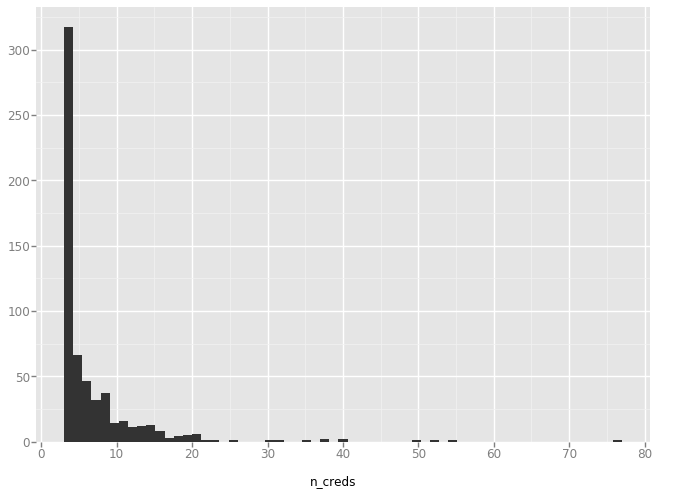

<ggplot: (297108989)>

In [20]:
# Lets choose a cutoff threshold:
thresh = 3
ggplot(pd.DataFrame([x[1] for x in counts if x[1] >= thresh], columns=['n_creds']), 
       aes(x='n_creds')) + geom_histogram(bins=round(len(counts)**(1/2.0)))

In [21]:
# final list of credits
final_creds = [x[0] for x in counts if x[1] >= thresh and x[0] is not None]

# create credits lookup
for k, values in clean_parse.items():
    clean_parse[k] = [re.sub(r'\([^)]*\)', '', v) for v in values if v in final_creds]

# create artist:id lookup
final_creds = []
for v in clean_parse.values():
    final_creds.extend(v)
final_creds = list(set(final_creds))

# create lookups for nodes
ghost2id = {}; id2ghost = {}
for k, v in enumerate(final_creds):
    id2ghost[k]=v
    ghost2id[v]=k

In [22]:
# pivot credits long for node statistics
edges = []; cred_long = []
for k, v in clean_parse.items():
    if len(v)>0:
        track = all_tracks.loc[k]
        for cred in v:
            cred_long.append((cred, track['art_1'], track['title'], track['year'], track['rank'], track['weeks'], track['uri']))
            
        # create distinct edge combinations
        for combo in combinations(v, r=2):
            edges.append((combo[0], combo[1], track['art_1'], track['title'], track['year'], track['rank'], track['weeks'], track['uri']))

nodes = pd.DataFrame.from_records(cred_long, columns=['ghost', 'artist', 'title', 'year', 'rank', 'weeks', 'uri'])
edges = pd.DataFrame.from_records(edges, 
                                  columns=['ghost_1', 'ghost_2', 'artist', 'title', 'year', 'rank', 'weeks', 'uri'])

In [23]:
# Get top 3 cowriters for each ghost and store as html ordered list
cowriters = pd.concat([edges[['ghost_1', 'ghost_2']], 
                       edges[['ghost_2', 'ghost_1']].rename(index=str, columns={"ghost_1": "ghost_2", "ghost_2": "ghost_1"})], axis=0, ignore_index=True)\
              .groupby(by=['ghost_1', 'ghost_2']).size().rename('counts').reset_index()
    
cowriters['rank'] = cowriters.sort_values(by=['ghost_1','ghost_2', 'counts'])\
                             .groupby('ghost_1')['counts'].rank(method='first', na_option='top')    
cowriters = cowriters.query('rank < 4')
cowriters['details'] = cowriters.ghost_2 + ' (' + cowriters['counts'].apply(str) + ')'
cowriters = cowriters.groupby(by='ghost_1').agg({'details': ['unique']}).reset_index()
cowriters.columns = ['_'.join(x).rstrip('_') for x in cowriters.columns.ravel()]
for i, row in cowriters.iterrows():
    cowriters.ix[i, 'details_unique'] = '<ol>{}</ol>'.format(''.join(['<li>'+d+'</li>' for d in row['details_unique']]))

In [24]:
# create edge and node stats
def summarize_node(row):
    sent = '{} had {} tracks in {}, peaking at {} and surviving {} total weeks on the charts.'
    if row.year_min==row.year_max:
        yr = row.year_min
    else:
        yr = str(row.year_min)+'-'+str(row.year_max)
    return(sent.format(row.ghost, row.year_count, yr, row.rank_min, row.weeks_sum))

nodes = nodes.groupby(by='ghost').agg({'weeks':['max', 'mean', 'sum'], 
                                       'rank': ['min', 'mean'],
                                       'year': ['min', 'max', 'count'], 
                                       'uri': ['unique']}).reset_index()
nodes.columns = ['_'.join(x).rstrip('_') for x in nodes.columns.ravel()]
nodes['description'] = nodes.apply(lambda row: summarize_node(row), axis=1)
nodes = pd.merge(nodes, cowriters, how='left', left_on='ghost', right_on='ghost_1')

In [30]:
# Delete my current "ghosts" playlists
plists = spt.user_playlists('hoyablues', limit=50)['items']
has_ghosts = np.sum(1 for plist in plists if plist['name'][:5]=='Ghost')

while has_ghosts!=0:
    for plist in plists:
        if plist['name'][:5]=='Ghost':
            spt.user_playlist_unfollow('hoyablues', plist['id'])     
    plists = spt.user_playlists('hoyablues', limit=50)['items']
    has_ghosts = np.sum(1 for plist in plists if plist['name'][:5]=='Ghost')

In [32]:
# Create a playlist for each ghost
nodes['pid'] = ''
for i, row in nodes.iterrows():
    tracks = [t for t in row['uri_unique'] if t is not None and len(t)==36]
    playlist = spt.user_playlist_create('hoyablues', 'Ghost :: '+row['ghost'])
    spt.user_playlist_add_tracks('hoyablues', playlist_id=playlist['id'], tracks=tracks)
    nodes.ix[i, 'pid'] = playlist['id']

In [33]:
# group up the edge connections
def summarize_edge(row):
    sent = '{} & {} worked on {} {} together, peaking at {}.'
    if row.year_count > 1:
        pl = 'songs'
    else:
        pl = 'song'
    return(sent.format(row.ghost_1, row.ghost_2, row.year_count, pl, row.rank_min))

edges = edges.groupby(by=['ghost_1', 'ghost_2']).agg({'weeks': ['max', 'mean', 'sum'], 
                                              'rank':  ['min', 'mean'],
                                              'year':  ['min', 'max', 'count']}).reset_index()
edges.columns = ['_'.join(x).rstrip('_') for x in edges.columns.ravel()]
edges['description'] = edges.apply(lambda row: summarize_edge(row), axis=1)
edges.head()

,ghost_1,ghost_2,weeks_max,weeks_mean,weeks_sum,rank_min,rank_mean,year_min,year_max,year_count,description
0,40-Love,Allen Ritter,19,19.0,19,37,37.0,2013,2013,1,40-Love & Allen Ritter worked on 1 song togeth...
1,40-Love,Anthony Palman,34,34.0,34,7,7.0,2011,2011,1,40-Love & Anthony Palman worked on 1 song toge...
2,40-Love,Aubrey Graham,20,20.0,20,25,25.0,2010,2010,1,40-Love & Aubrey Graham worked on 1 song toget...
3,40-Love,Axlfolie,10,8.2,41,33,40.6,2016,2016,5,"40-Love & Axlfolie worked on 5 songs together,..."
4,40-Love,Boi-1da,19,10.0,60,33,40.0,2013,2016,6,"40-Love & Boi-1da worked on 6 songs together, ..."


# OUTPUT GRAPH FILES

In [34]:
import networkx as nx

G = nx.Graph()
for index, e in edges.iterrows():
    G.add_edge(ghost2id[e.ghost_1], ghost2id[e.ghost_2], weight=e.year_count, label=e.description)
G.number_of_nodes()

594

In [35]:
for index, n in nodes.iterrows():
    try:
        cowriters = n.details_unique.replace('"', '').replace("'", "")
    except:
        cowriters = ''
    G.add_node(ghost2id[n.ghost], size=n.year_count, weight=n.year_count, 
               info  = cowriters,
               name  = n.ghost,
               label = n.description, playlist=n.pid)

pos = nx.spring_layout(G)

In [36]:
G.number_of_nodes()

603

In [37]:
nx.write_graphml(G, "g.graphml")

In [ ]:
# with open('../02_data/graph.json', 'w') as outfile:
#     # beginning
#     outfile.write('{\n  "graph": [],\n  "links": [\n')
#     # end section
#     for i, e in edges.iterrows():
#         if i==max(edges.index):
#             end = '}],'
#         else:
#             end = '},'
#         outfile.write('    {}"source": {}, "target": {}{}\n'.format('{', ghost2id[e.ghost_1], ghost2id[e.ghost_2], end))
#     # node section
#     outfile.write('  "nodes": [\n')
#     for i, n in nodes.iterrows():
#         if i==max(nodes.index):
#             end = '}],'
#         else:
#             end = '},'
#         outfile.write('    {}"size": {}, "score": {}, "node_id": {}, "id": "{}", "type": "circle"{}\n'
#                       .format('{', (n.year_count*2)**500, round(n.rank_min), ghost2id[n.ghost], n.ghost.replace('"', '').replace("'", ''), end))
#     outfile.write('  "directed": false,\n  "multigraph": false\n}')